In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

import imutils
import cv2

In [18]:
# Calculate mean scan profile from blank scan

Path = '/srv/home/chenyu/DEbackup/062819/S8/'
Name = 'S8'
rx = 150
ry = 150
PACBED = np.zeros((512,512))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(Path+'npy/'+Name+'_'+format(filenum,'05')+'.npy')
        PACBED = PACBED + frame

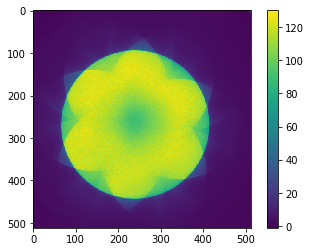

In [90]:
Path = '/srv/home/chenyu/DEbackup/062819/S3/'
PACBED = np.load(Path + 'PACBED.npy')
plt.imshow(PACBED)
plt.colorbar()

In [83]:
# Calculate mean scan profile from blank scan

RefPath = '/srv/home/chenyu/DEbackup/062819/S0/'
RefName = 'S0'
BeamLevel = 0
rx = 150
ry = 150
AccumulatedFrame = np.zeros((512,512))
for ix in range(rx):
    for iy in range(ry):
        filenum = ix*rx+iy+1
        frame = np.load(RefPath+'npy/'+RefName+'_'+format(filenum,'05')+'.npy')
        BeamLevel = BeamLevel + np.sum(frame)
        AccumulatedFrame = AccumulatedFrame + frame
AccumulatedFrame = AccumulatedFrame / rx / ry
BeamLevel = BeamLevel / rx / ry

13741792.185638677


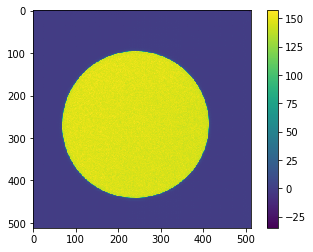

In [84]:
print(BeamLevel)
plt.imshow(AccumulatedFrame)
plt.colorbar()
np.save(RefPath + 'BeamLevel.npy', BeamLevel)
np.save(RefPath + 'AccumualtedFrame.npy', AccumulatedFrame)

/srv/home/chenyu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


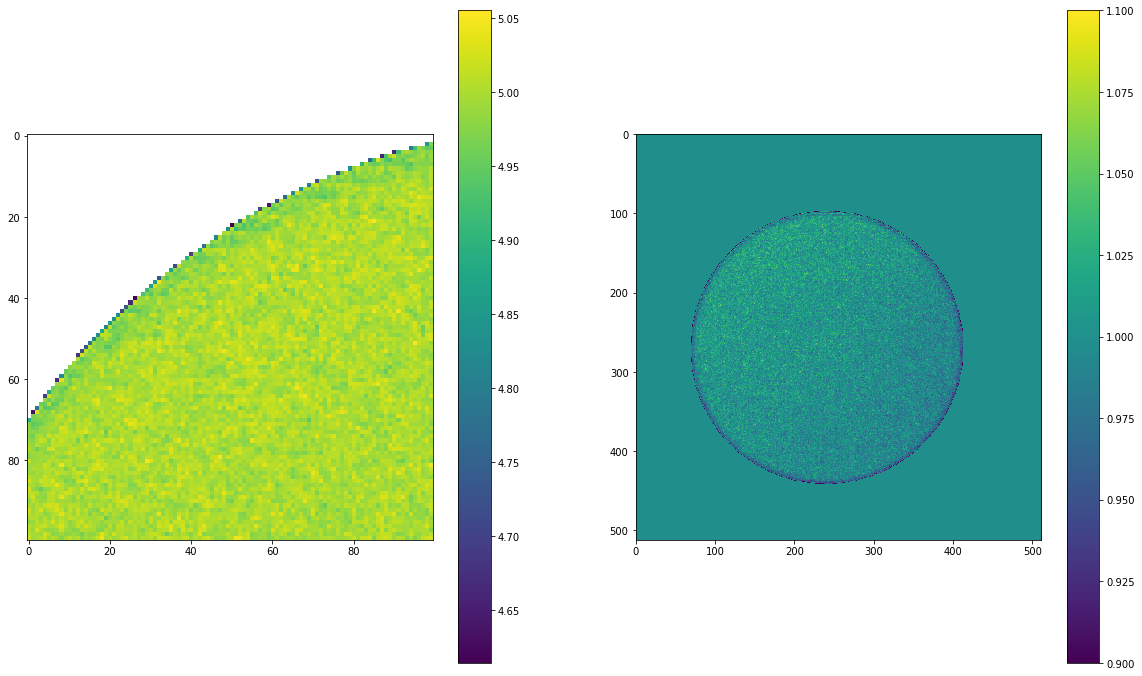

In [34]:
# Generate normalization mask
temp = AccumulatedFrame
temp[temp<0] = 0
fig = plt.figure(figsize=(20,12))
fig.add_subplot(121)
# tried to use 50 as threshold for mask1, will cause norm_mask value being too high, normalized exp intensity too low
mask1 = np.heaviside(AccumulatedFrame-100,1)
plt.imshow(np.log((temp*mask1)[100:200,100:200]))
plt.colorbar()

MeanBeamLevel = (mask1*AccumulatedFrame).sum()/np.count_nonzero(mask1)
norm_mask = AccumulatedFrame * mask1 / MeanBeamLevel
norm_mask[norm_mask==0] = 1
fig.add_subplot(122)
plt.imshow(norm_mask,clim=[0.9,1.1])
plt.colorbar()
np.save(RefPath + 'norm_mask.npy',norm_mask)

In [94]:
# Compare simulated PACBED from a unit cell to experiment PACBED
from scipy.ndimage import gaussian_filter

simpath = '/srv/home/chenyu/WS2_simulation/Test/Test/'

exppath = '/srv/home/chenyu/DEbackup/062819/S3/'
PACBED_exp = np.load(exppath+'PACBED.npy')
# thickness = np.load(exppath+'SrPeaks_thickness.npy')
# ABF = np.load(exppath+'ABF.npy')
# mask = np.heaviside(AccumulatedFrame-50,1)
mask = mask1
norm_mask = np.load('/srv/home/chenyu/DEbackup/062819/S0/norm_mask.npy')


# plt.imshow(PACBED_exp[0:100,0:100])
# plt.imshow(ABF[1:-1,:])
# plt.colorbar()

# PACBED_exp = PACBED_exp/BeamLevel
# PACBED_exp = (PACBED_exp*mask/norm_mask/BeamLevel)+PACBED_exp/BeamLevel*(1-mask)

PACBED_exp = (PACBED_exp*mask/norm_mask/BeamLevel)+PACBED_exp/BeamLevel*(1-mask)

expMask = np.zeros((69,69))
expMask[21:43,22:44] = 1
px_list = np.nonzero(expMask)
sim_cube = np.load(simpath+'depth0_slice10_110pmss.npy')
row_list = px_list[0]
col_list = px_list[1]
file_list= row_list*69+col_list+1
PACBED_sim = np.zeros((264,264))
# PACBED_sim = np.zeros((488,488))

for ifile in range(file_list.size):
    frame = sim_cube[row_list[ifile],col_list[ifile],:,:]
    PACBED_sim = PACBED_sim + frame
    
PACBED_sim = PACBED_sim / file_list.size / 32
PACBED_sim = gaussian_filter(PACBED_sim,sigma=0.0)
print(np.sum(PACBED_exp))
print(np.sum(PACBED_sim))
# print(np.mean(thickness))


0.8620151480947587
0.9822473606932527


In [95]:
# resample both simulation and experiment to a new grid, ranges from -40mrad to 40mrad with 1mrad/px

# dataset for 06/12/19
center_x = 240
center_y = 270
rotation = -20

final_size = 200

exp_pxsize = 0.148
sim_pxsize = 0.625

# Use a symmetric cutoff angle

collection_angle = min([center_x,center_y,512-center_x,512-center_y])
collection_angle = collection_angle * exp_pxsize

exp_x = np.linspace(-exp_pxsize*center_x, exp_pxsize*(511-center_x), num=512)
exp_y = np.linspace(-exp_pxsize*center_y, exp_pxsize*(511-center_y), num=512)
f_exp = scipy.interpolate.RectBivariateSpline(exp_y,exp_x,PACBED_exp)
final_x = np.linspace(-collection_angle,collection_angle,num=final_size)
final_y = np.linspace(-collection_angle,collection_angle,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
exp_recon = np.zeros((final_size,final_size))
exp_recon = f_exp.ev(final_xx,final_yy)
# exp_recon = exp_recon / exp_pxsize / exp_pxsize * sim_pxsize * sim_pxsize
        
sim_x = np.linspace(-sim_pxsize*132, sim_pxsize*(264-132), num=264)
# sim_x = np.linspace(-sim_pxsize*244, sim_pxsize*(488-244), num=488)
sim_y = sim_x
f_sim = scipy.interpolate.RectBivariateSpline(sim_x,sim_y,PACBED_sim)
sim_recon = np.zeros((final_size,final_size))
final_x = np.linspace(-collection_angle,collection_angle,num=final_size)
final_y = np.linspace(-collection_angle,collection_angle,num=final_size)
final_xx, final_yy = np.meshgrid(final_x,final_y)
final_xx_rotated = final_xx*math.cos(math.radians(rotation))-final_yy*math.sin(math.radians(rotation))
final_yy_rotated = final_yy*math.cos(math.radians(rotation))+final_xx*math.sin(math.radians(rotation))
sim_recon = f_sim.ev(final_xx_rotated,final_yy_rotated)
sim_recon = sim_recon / sim_pxsize / sim_pxsize * exp_pxsize * exp_pxsize

print('Collection angle limit: ' + str(collection_angle))

Collection angle limit: 35.519999999999996


[]

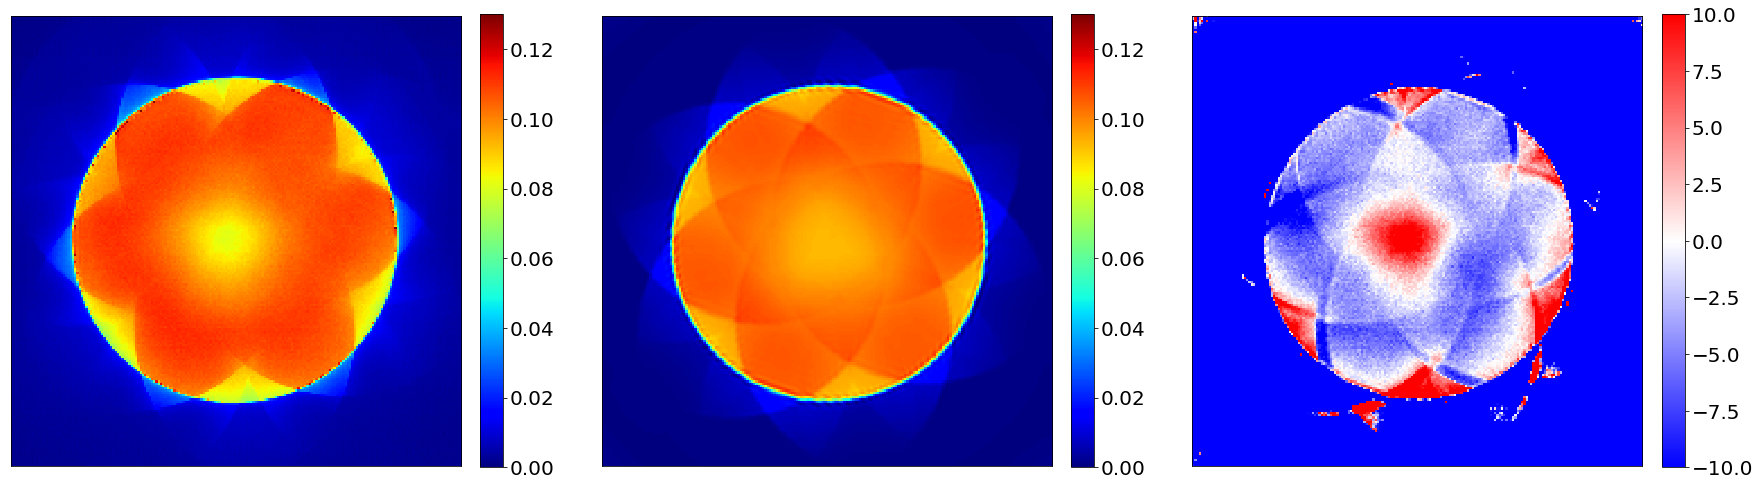

In [101]:
fig, ax = subplots(1,3,figsize=(30, 10))
im0 = ax[0].imshow(exp_recon*1.25*10000,clim=[0,0.13],cmap = plt.get_cmap('jet'))
im1 = ax[1].imshow(sim_recon*10000,clim=[0,0.13],cmap = plt.get_cmap('jet'))
# im1 = ax[1].imshow(sim_recon*10000)
cbar = plt.colorbar(im0,ax = ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
cbar = plt.colorbar(im1,ax = ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)
im2 = ax[2].imshow(((sim_recon-exp_recon*1.25)/sim_recon*100),clim=[-10,10],cmap=plt.get_cmap('bwr'))
cbar = plt.colorbar(im2,ax = ax[2], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

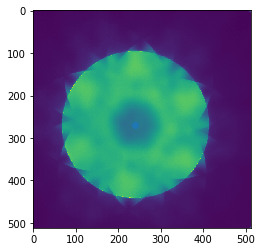

In [79]:
plt.imshow(PACBED_exp)
plt.scatter(240,270)